In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

df = pd.read_csv(r"C:\Users\ralph\OneDrive\Desktop\jupyter\datainterpretation\data\devices-report-batt-signal.csv")
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Columns: 121 entries, time to Signal 40
dtypes: float64(76), int64(44), object(1)
memory usage: 2.9+ MB


,Temperature 1,Battery 1,Signal 1,Temperature 2,Battery 2,Signal 2,Temperature 3,Battery 3,Signal 3,Temperature 4,...,Signal 37,Temperature 38,Battery 38,Signal 38,Temperature 39,Battery 39,Signal 39,Temperature 40,Battery 40,Signal 40
count,3097.000000,3097.000000,3097.000000,3097.000000,3097.000000,3097.000000,3097.000000,3097.000000,3097.000000,3097.000000,...,3097.000000,3097.0,3097.0,3097.0,3097.000000,3097.000000,3097.000000,3097.0,3097.0,3097.0
mean,22.380727,3.018405,52.117210,21.781492,3.018899,56.816597,21.749202,3.012893,50.606070,21.458692,...,17.697126,0.0,0.0,0.0,7.589487,1.096487,9.690991,0.0,0.0,0.0
std,1.981277,0.203504,16.389679,1.822581,0.203537,16.841178,1.866592,0.203129,17.892583,1.840000,...,21.652991,0.0,0.0,0.0,10.003588,1.444905,13.976231,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,21.880000,3.030000,36.000000,21.180000,3.030000,41.000000,21.190000,3.020000,36.000000,20.960000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,22.810000,3.030000,58.000000,22.110000,3.030000,69.000000,22.230000,3.030000,60.000000,21.880000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,23.480000,3.030000,67.000000,22.770000,3.040000,70.000000,22.740000,3.030000,64.000000,22.480000,...,46.000000,0.0,0.0,0.0,20.510000,2.990000,19.000000,0.0,0.0,0.0
max,24.550000,3.040000,89.000000,24.090000,3.040000,90.000000,25.580000,3.030000,82.000000,24.200000,...,55.000000,0.0,0.0,0.0,21.440000,3.030000,50.000000,0.0,0.0,0.0


In [2]:
df.columns

Index(['time', 'Temperature 1', 'Battery 1', 'Signal 1', 'Temperature 2',
       'Battery 2', 'Signal 2', 'Temperature 3', 'Battery 3', 'Signal 3',
       ...
       'Signal 37', 'Temperature 38', 'Battery 38', 'Signal 38',
       'Temperature 39', 'Battery 39', 'Signal 39', 'Temperature 40',
       'Battery 40', 'Signal 40'],
      dtype='object', length=121)

# sort time

In [3]:
df['time'] = pd.to_datetime(
    df['time'],
    format='%B %d, %Y %I:%M %p',
    errors='coerce'
)
df = df.sort_values('time')

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values('time')

# detect

In [4]:
signal_cols = [col for col in df.columns if 'Signal' in col]
signal_changes = df[['time'] + signal_cols].copy()

# Find when a device’s signal went from nonzero to zero
for col in signal_cols:
    signal_changes[col + '_lost'] = (df[col].shift(1) > 0) & (df[col] == 0)

loss_dates = {}
for col in signal_cols:
    lost_times = df.loc[signal_changes[col + '_lost'], 'time']
    if not lost_times.empty:
        loss_dates[col] = lost_times.iloc[0]  # first loss occurrence


# event data frame

In [6]:
events = []

for col in signal_cols:
    df[f'prev_{col}'] = df[col].shift(1)
    
    lost_rows = df[(df[f'prev_{col}'] > 0) & (df[col] == 0)][['time']]
    lost_rows = lost_rows.assign(Device=col, Status='Lost Signal')
    
    gained_rows = df[(df[f'prev_{col}'] == 0) & (df[col] > 0)][['time']]
    gained_rows = gained_rows.assign(Device=col, Status='Gained Signal')
    
    events.append(pd.concat([lost_rows, gained_rows]))

# Combine all events

In [7]:
events_df = pd.concat(events).sort_values('time').reset_index(drop=True)

# Detect gateway update
### if many devices change signal at the same timestamp, mark as potential gateway update

In [8]:
threshold = max(5, len(signal_cols)//10)  # e.g., 10% of devices or at least 5
events_count = events_df.groupby('time').size().reset_index(name='Count')
events_df = events_df.merge(events_count, on='time')

events_df['Gateway_Update_Flag'] = events_df['Count'] >= threshold


# Preview event log

In [9]:
print(events_df.head(20))

                  time     Device         Status  Count  Gateway_Update_Flag
0  2025-09-11 20:38:00  Signal 35  Gained Signal      1                False
1  2025-09-11 21:20:00  Signal 16  Gained Signal      1                False
2  2025-09-11 21:24:00  Signal 28  Gained Signal      2                False
3  2025-09-11 21:24:00  Signal 17  Gained Signal      2                False
4  2025-09-11 21:25:00  Signal 29  Gained Signal      1                False
5  2025-09-11 21:26:00  Signal 15  Gained Signal      1                False
6  2025-09-11 21:27:00  Signal 34  Gained Signal      1                False
7  2025-09-11 21:28:00  Signal 13  Gained Signal      3                False
8  2025-09-11 21:28:00  Signal 32  Gained Signal      3                False
9  2025-09-11 21:28:00  Signal 36  Gained Signal      3                False
10 2025-09-11 21:33:00  Signal 37  Gained Signal      1                False
11 2025-09-11 21:38:00  Signal 18  Gained Signal      1                False

# Group by date to see daily summary

In [10]:
events_df['date'] = events_df['time'].dt.date
daily_summary = events_df.groupby(['date', 'Status']).size().unstack(fill_value=0)
daily_summary['Gateway_Update'] = events_df.groupby('date')['Gateway_Update_Flag'].max()
print(daily_summary)

Status      Gained Signal  Lost Signal  Gateway_Update
date                                                  
2025-09-11             12            0           False
2025-09-12              0           13            True
2025-09-15             18           19            True
2025-09-16             20            0            True
2025-09-18              1            1           False
2025-09-19             73           87            True
2025-09-20              1            2           False
2025-09-21              0            3           False
2025-09-22              6            2           False
2025-09-23              3            2           False
2025-09-24              1            0           False
2025-09-26             23           26            True
2025-09-27              1            0           False
2025-09-28              0            1           False
2025-09-29             22           25            True
2025-09-30              1            0           False


# most date with the highest lost signal

Date with most Lost Signal: 2025-09-19
Date with most Gained Signal: 2025-09-19

Daily Summary:
Status        date  Gained Signal  Lost Signal
0       2025-09-11             12            0
1       2025-09-12              0           13
2       2025-09-15             18           19
3       2025-09-16             20            0
4       2025-09-18              1            1
5       2025-09-19             73           87
6       2025-09-20              1            2
7       2025-09-21              0            3
8       2025-09-22              6            2
9       2025-09-23              3            2
10      2025-09-24              1            0
11      2025-09-26             23           26
12      2025-09-27              1            0
13      2025-09-28              0            1
14      2025-09-29             22           25
15      2025-09-30              1            0


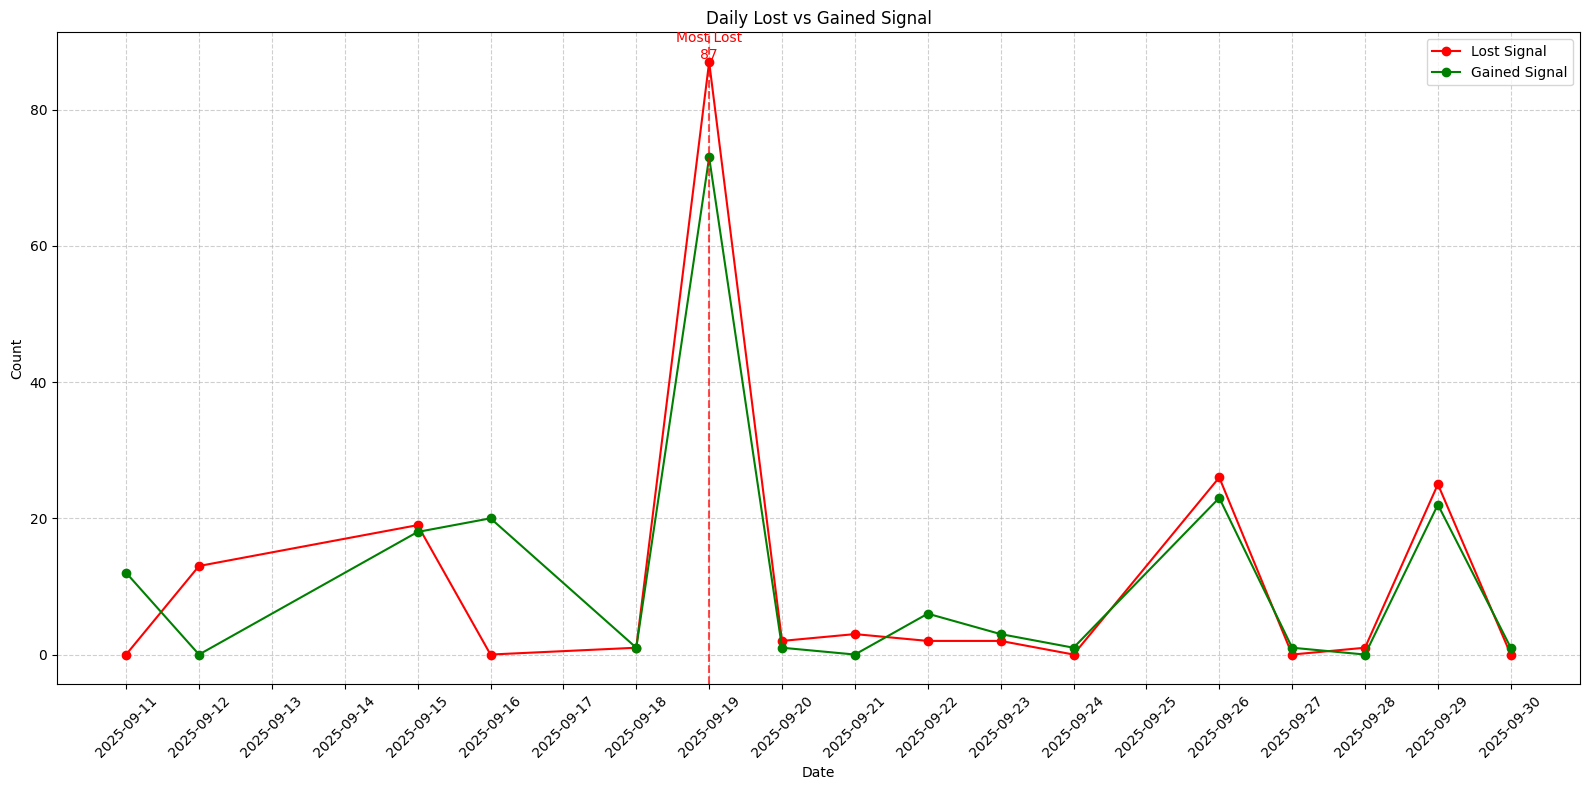

In [14]:
events = []

for col in signal_cols:
    df[f'prev_{col}'] = df[col].shift(1)
    
    # Lost: was >0, now 0
    lost_rows = df[(df[f'prev_{col}'] > 0) & (df[col] == 0)][['time']]
    lost_rows = lost_rows.assign(Device=col, Status='Lost Signal')
    
    # Gained: was 0, now >0
    gained_rows = df[(df[f'prev_{col}'] == 0) & (df[col] > 0)][['time']]
    gained_rows = gained_rows.assign(Device=col, Status='Gained Signal')
    
    events.append(pd.concat([lost_rows, gained_rows]))

# --- Combine all events ---
events_df = pd.concat(events).sort_values('time').reset_index(drop=True)

# --- Create daily summary ---
events_df['date'] = events_df['time'].dt.date
daily_summary = events_df.groupby(['date', 'Status']).size().unstack(fill_value=0)
daily_summary = daily_summary.reset_index()

# --- Identify the date with most lost signals ---
most_lost_date = daily_summary.loc[daily_summary['Lost Signal'].idxmax(), 'date']
most_gained_date = daily_summary.loc[daily_summary['Gained Signal'].idxmax(), 'date']

print("Date with most Lost Signal:", most_lost_date)
print("Date with most Gained Signal:", most_gained_date)
print("\nDaily Summary:")
print(daily_summary)

# --- Plot ---
most_lost_date = daily_summary.loc[daily_summary['Lost Signal'].idxmax(), 'date']
most_lost_count = daily_summary['Lost Signal'].max()

plt.figure(figsize=(16,8))
plt.plot(daily_summary['date'], daily_summary['Lost Signal'], color='red', marker='o', label='Lost Signal')
plt.plot(daily_summary['date'], daily_summary['Gained Signal'], color='green', marker='o', label='Gained Signal')

plt.title("Daily Lost vs Gained Signal")
plt.xlabel("Date")
plt.ylabel("Count")

# --- Show more dates on x-axis ---
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# --- Highlight the date with most lost signals ---
plt.axvline(pd.to_datetime(most_lost_date), color='red', linestyle='--', alpha=0.7)
plt.text(pd.to_datetime(most_lost_date), most_lost_count + 0.5,
         f'Most Lost\n{most_lost_count}', color='red', fontsize=10, ha='center')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()